# Regresión logística y validación cruzada

**1-** En este primer paso se importa la base de datos anteriormente trabajada en el proyecto la cual es una base de datos del 2022 de unidades de producción agropecuaria, tras limpieza, eliminación de outliers (criterio de Tukey) y control de colinealidad. La variable de salida es binaria: alta producción (1) si el valor de Total UP agropecuaria activas está por encima de la mediana, y baja (0) en caso contrario. Esta decisión asegura clases balanceadas y facilita la interpretación del clasificador.

In [13]:
import pandas as pd
import numpy as np

df = pd.read_csv("CA2022_Cultivos_Superficie_Produccion.csv", encoding="latin-1")

# Eliminar columnas no necesarias
df = df.drop(columns=["NOM_MUN", "NOMBRE", "ENTIDAD"], errors="ignore")
target = "Total UP agropecuaria activas"
df = df.dropna(subset=[target])

#  Outliers (Tukey) 
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lim_inf = Q1 - 1.5 * IQR
lim_sup = Q3 + 1.5 * IQR
df_tukey = df[(df[target] >= lim_inf) & (df[target] <= lim_sup)].copy()

# Colinealidad
base = df_tukey if 'df_tukey' in globals() else df
y = base[target].copy()
cols_excluir = {target, "UP Agricolas", "y_winz", "y_log", "es_outlier"} & set(base.columns)
X = (
    base.drop(columns=list(cols_excluir), errors="ignore")
        .select_dtypes(include="number")
        .copy()
)
#  Eliminar colinealidad alta 
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
X = X.drop(columns=to_drop, errors="ignore")

# Base final 
df_final = X.copy()
df_final[target] = y
df_final.head(10)

,UP Argri Riego ( R ),P UP Riego,UP Riego Gravedad (RG),UP RG Canales revestidos,UP RG Canales de Tierra,UP RG Tubería De Compuerta,UP R Por Microaspersión,UP R Por Aspersión,UP R Por Aspersión Pivote Central,UP R Por Aspersión Avance Frontal,UP R Por Aspersión Cañón,UP R Por Aspersores,UP R Sistema De Goteo,UP R Mediante Algún Otro Sistema,Total UP agropecuaria activas
1,629.0,56.756757,59.943978,8.411215,22.429907,78.037383,10.364146,37.815126,28.148148,4.444444,18.518519,62.222222,14.565826,0.280112,3098.0
2,1033.0,75.217812,45.173745,3.418803,21.367521,79.487179,5.276705,8.365508,9.230769,1.538462,9.230769,89.230769,63.835264,0.128700,3302.0
3,1524.0,57.611549,43.735763,3.125000,56.510417,48.177083,27.904328,35.876993,1.269841,0.317460,10.158730,91.428571,11.617312,4.669704,2659.0
4,663.0,66.515837,83.219955,28.337875,18.801090,70.299728,0.907029,3.174603,14.285714,0.000000,7.142857,78.571429,32.426304,0.680272,1049.0
5,589.0,60.611205,75.630252,8.148148,37.037037,62.962963,2.801120,14.005602,10.000000,0.000000,16.000000,76.000000,10.644258,7.563025,1451.0
6,582.0,68.384880,42.462312,5.917160,17.159763,81.065089,5.276382,16.331658,20.000000,1.538462,3.076923,86.153846,65.577889,0.502513,989.0
7,932.0,64.914163,53.719008,3.692308,36.615385,73.230769,3.801653,5.123967,16.129032,9.677419,0.000000,83.870968,63.140496,0.661157,1709.0
8,264.0,73.863636,95.897436,74.866310,24.598930,49.197861,3.589744,5.641026,0.000000,0.000000,54.545455,54.545455,4.102564,0.000000,1060.0
9,704.0,69.318182,69.877049,24.340176,20.527859,78.299120,2.663934,8.811475,0.000000,6.976744,0.000000,95.348837,41.393443,1.024590,1586.0
10,317.0,74.763407,90.295359,1.869159,5.607477,94.392523,1.265823,5.063291,58.333333,8.333333,25.000000,25.000000,9.282700,0.421941,2199.0


**2-** Dividimos el dataset en Train (80%) y Test (20%) conservando la proporción de clases (alta producción / baja producción). Se uso(*stratify=y_bin*) en (*train_test_split*) para evitar que por azar el conjunto de prueba quede sesgado hacia una clase, así se mantiene el balance de clases. Se muestra en una tabla con el porcentaje de cada clase en Original / Train / Test para verificar que no haya cambios bruscos: en este caso se mantuvo 50/50 (Original ≈ 50/50, Train ≈ 50/50, Test ≈ 50/50), confirmando una separación equilibrada.

In [17]:
from sklearn.model_selection import train_test_split

assert set(pd.Series(y_bin).unique()) <= {0, 1}, "y_bin debe ser 0/1."

X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)
def proporciones(nombre, serie):
    p = serie.value_counts(normalize=True).sort_index()
    return pd.Series(
        {"Clase 0": p.get(0, np.nan), "Clase 1": p.get(1, np.nan)},
        name=nombre
    )
resumen = pd.concat([
    proporciones("Original", y_bin),
    proporciones("Train", y_train),
    proporciones("Test", y_test)
], axis=1).T
display(resumen.style.format("{:.3f}"))

,Clase 0,Clase 1
Original,0.500,0.500
Train,0.500,0.500
Test,0.501,0.499


**3-** Para estimar el desempeño fuera de muestra de la regresión logística (clasificar alta vs baja producción), utilizamos cross_validate con StratifiedKFold (k=5). Esto divide el conjunto de entrenamiento en 5 folds que conservan la proporción 0/1; en cada iteración se entrena en 4 folds y se evalúa en el restante, repitiendo el proceso 5 veces.

Se empleó un Pipeline con StandardScaler este evita data leakage y mejora la estabilidad numérica del modelo. Reportamos accuracy, recall, precision, F1 y ROC-AUC.

Las tablas nos arrojaron lo siguiente:
- Recall: 0.574 ± 0.026 → el modelo identifica 57% de los casos de alta producción (al aumentar recall se reducen falsos negativos).

- Precision: 0.747 ± 0.036 → de las predicciones “alta producción”, 75% realmente lo son (25% falsos positivos).

- F1: 0.649 ± 0.025 → equilibrio entre recall y precision; desempeño consistente.

- ROC-AUC: 0.756 ± 0.029 → discriminación moderada-buena y estable entre folds.

- Accuracy: 0.689 ± 0.023 → 69% de aciertos totales.

El modelo tiende a ser conservador (alta precisión frente a un recall moderado): cuando predice “alta producción” suele acertar, aunque deja pasar algunos positivos. La baja desviación estándar en todas las métricas indica estabilidad del rendimiento.

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate

pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(solver="lbfgs", max_iter=1000))  
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy":  "accuracy",
    "recall":    "recall",
    "precision": "precision",
    "f1":        "f1",
    "roc_auc":   "roc_auc"
}
cv_res = cross_validate(
    pipe, X_train, y_train,
    cv=cv, scoring=scoring, return_train_score=False
)
tabla_cv = pd.DataFrame({
    "accuracy":  cv_res["test_accuracy"],
    "recall":    cv_res["test_recall"],
    "precision": cv_res["test_precision"],
    "f1":        cv_res["test_f1"],
    "roc_auc":   cv_res["test_roc_auc"],
})
display(tabla_cv.round(3))
resumen_cv = pd.DataFrame({
    "métrica":  tabla_cv.columns,
    "media":    tabla_cv.mean().values,
    "desv_std": tabla_cv.std(ddof=1).values
}).sort_values("métrica")
display(resumen_cv.style.format({"media":"{:.3f}", "desv_std":"{:.3f}"}))

,accuracy,recall,precision,f1,roc_auc
0,0.683,0.551,0.750,0.636,0.754
1,0.682,0.565,0.738,0.640,0.736
2,0.658,0.565,0.693,0.623,0.722
3,0.709,0.571,0.789,0.662,0.794
4,0.715,0.620,0.765,0.685,0.776


,métrica,media,desv_std
0,accuracy,0.689,0.023
3,f1,0.649,0.025
2,precision,0.747,0.036
1,recall,0.574,0.026
4,roc_auc,0.756,0.029


**4-** Se ajustó la regresión logística con todo el set de entrenamiento y, en el set de prueba, calculé las probabilidades para cada observación. Al ser un clasificador probabilístico, evalué tres umbrales de decisión:

- Umbral 0.3: Accuracy 0.594 · Recall 0.865 · Especificidad 0.325 · Precisión 0.561 · F1 0.680.
Maximiza la detección de positivos (recall) y el F1, pero cae la especificidad (muchos falsos positivos).

- Umbral 0.5: Accuracy 0.649 · Recall 0.509 · Especificidad 0.788 · Precisión 0.705 · F1 0.591.
Buena especificidad y precisión, con recall moderado.

- Umbral 0.7: Accuracy 0.662 · Recall 0.357 · Especificidad 0.965 · Precisión 0.911 · F1 0.512.
Minimiza falsos positivos (muy alta especificidad y precisión), pero se escapan muchos positivos (recall bajo).

En Conclusión:

- Si busco equilibrio general, me quedo con t = 0.5.

- Si la prioridad es no perder positivos, elegiría t = 0.3 (mejor F1 y recall).

- Si la prioridad es evitar falsos positivos, usaría t = 0.7.

Primeras 10 probabilidades: [0.97  0.279 0.279 0.485 0.993 0.489 0.279 0.455 0.299 0.335]


,umbral,accuracy,sensibilidad,especificidad,precision,f1
1,0.3,0.594,0.865,0.325,0.561,0.680
0,0.5,0.649,0.509,0.788,0.705,0.591
2,0.7,0.662,0.357,0.965,0.911,0.512


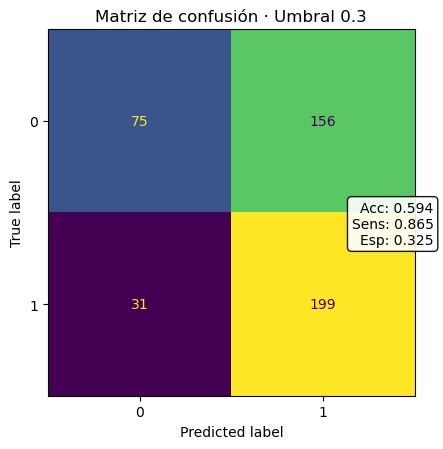

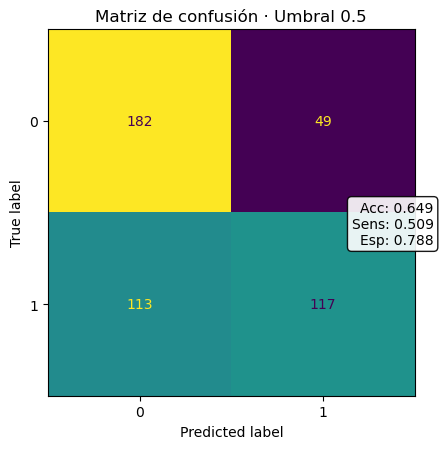

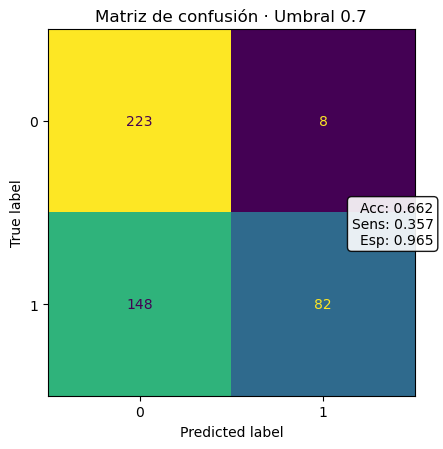

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, recall_score, precision_score, f1_score
)

pipe.fit(X_train, y_train)
y_prob = pipe.predict_proba(X_test)[:, 1]
print("Primeras 10 probabilidades:", np.round(y_prob[:10], 3))

def eval_thresholds(y_true, y_prob, thresholds=(0.5, 0.3, 0.7)):
    filas, cms = [], {}
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        acc  = accuracy_score(y_true, y_pred)
        sens = recall_score(y_true, y_pred)                 
        esp  = tn / (tn + fp) if (tn + fp) else np.nan      
        prec = precision_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred)

        filas.append({
            "umbral": t, "accuracy": acc, "sensibilidad": sens,
            "especificidad": esp, "precision": prec, "f1": f1,
            "TN": tn, "FP": fp, "FN": fn, "TP": tp
        })
        cms[t] = cm

    tabla = pd.DataFrame(filas).sort_values("umbral")
    return tabla, cms

tabla_4, cms_4 = eval_thresholds(y_test, y_prob, thresholds=(0.5, 0.3, 0.7))
display(tabla_4[["umbral","accuracy","sensibilidad","especificidad","precision","f1"]].round(3))

for _, fila in tabla_4.iterrows():
    t = fila["umbral"]
    disp = ConfusionMatrixDisplay(cms_4[t], display_labels=[0, 1])
    fig, ax = plt.subplots(figsize=(4.6, 4.6))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"Matriz de confusión · Umbral {t}")
    fig.text(
        0.98, 0.5,
        f"Acc: {fila['accuracy']:.3f}\nSens: {fila['sensibilidad']:.3f}\nEsp: {fila['especificidad']:.3f}",
        ha="right", va="center",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.9)
    )
    plt.tight_layout()
    plt.show()

**5-** Se trazó la curva ROC con las probabilidades del modelo en el conjunto de prueba. La curva se sitúa claramente por encima de la diagonal (azar), y el área bajo la curva fue AUC = 0.741. Esto significa que, al comparar al azar un caso de alta producción y uno de baja, el modelo asigna una puntuación mayor al caso correcto aproximadamente el 74% de las veces, lo que indica capacidad de discriminación moderada y útil. La ROC no depende del umbral ni del balance de clases, por ello la elección operativa del umbral (vista en el punto 4) debe ajustarse según si se prioriza detectar más positivos (mayor sensibilidad) o reducir falsas alarmas (mayor especificidad). En conjunto, los resultados son coherentes con la validación cruzada y respaldan el uso del modelo para distinguir entre alta y baja producción.

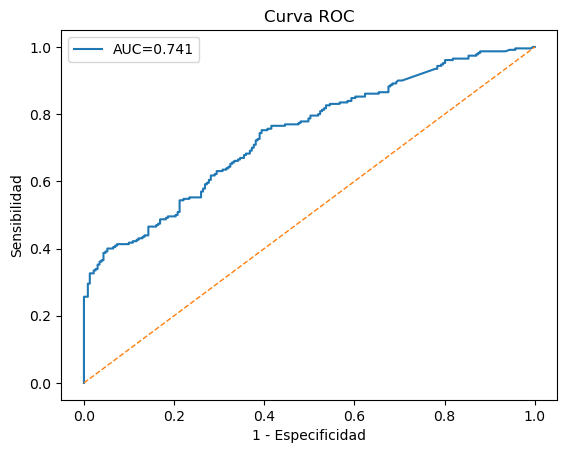

AUC: 0.7413


In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob = pipe.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], "--", lw=1)
plt.xlabel("1 - Especificidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC")
plt.legend()
plt.show()

print(f"AUC: {auc:.4f}")

**6-** En este punto interpretamos la regresión logística para entender cómo cada variable se asocia con la probabilidad de alta producción (clase 1). Trabajamos con el modelo final (Pipeline = StandardScaler + LogisticRegression) y extraemos sus coeficientes estandarizados (β) junto con sus odds ratios (OR = e^β). Previamente controlamos la colinealidad alta para evitar inestabilidad en los coeficientes y hacer la lectura más confiable.

- Signo de β: positivo ⇒ aumenta la probabilidad de alta producción; negativo ⇒ la reduce.

- Odds ratio (OR): es e^β (exponencial de β). Convierte el coeficiente a un cambio multiplicativo en las odds (p/(1−p)). OR > 1 ⇒ favorece la clase 1; OR < 1 ⇒ la desfavorece.

In [30]:
import numpy as np
import pandas as pd

feat = X_train.columns
coef = pipe.named_steps["clf"].coef_.ravel()  
odds = np.exp(coef)                           

tabla_coef = (
    pd.DataFrame({"feature": feat, "beta": coef, "odds_ratio": odds})
      .sort_values("beta", key=lambda s: s.abs(), ascending=False)
      .reset_index(drop=True)
)
display(tabla_coef.head(12).round(3))

,feature,beta,odds_ratio
0,UP Argri Riego ( R ),2.115,8.293
1,UP R Por Aspersores,0.278,1.321
2,UP R Por Aspersión,-0.250,0.779
3,UP R Por Aspersión Pivote Central,0.208,1.231
4,UP Riego Gravedad (RG),-0.200,0.818
5,UP R Por Microaspersión,0.190,1.209
6,UP R Por Aspersión Cañón,0.172,1.187
7,UP RG Canales revestidos,-0.089,0.915
8,UP R Por Aspersión Avance Frontal,0.077,1.080
9,UP R Sistema De Goteo,0.075,1.078


Con base a la tabla obtenemos las siguientes conclusiones:
 
- Mayor efecto positivo:
UP Argri Riego (R) → β=2.115, OR=8.293. Un aumento de +1 DE en esta variable multiplica ~8.3× las odds de alta producción. Es el factor más influyente.

- Efectos positivos moderados (presurizados):
Aspersores (OR=1.321), Aspersión pivote central (1.231), Microaspersión (1.209), Aspersión cañón (1.187), Avance frontal (1.080), Goteo (1.078) y P UP Riego (1.044). Todos favorecen la clase 1 con impactos de pequeños a medianos.

- Efectos negativos o débiles:
Riego por gravedad (RG) (OR=0.818) y UP R por Aspersión (global) (0.779) reducen la probabilidad de alta producción. Canales revestidos (0.915) y RG canales de tierra (0.971) muestran efectos pequeños/ligeros en contra.

En conclusión, las tecnologías de riego presurizado se asocian consistentemente con mayor probabilidad de alta producción, los esquemas de gravedad/canales tienden a asociarse con menor probabilidad.